In [67]:
# load single fif file

import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import signal

# load processed fif file
processed_dir = os.path.join('..', '..', 'processed')
resting_files = glob.glob(os.path.join(processed_dir, "*resting_state*.fif"))

raw = mne.io.read_raw_fif(resting_files[20], preload=True)

Opening raw data file ..\..\processed\resting_state_cleaned_27.fif...
    Range : 0 ... 182981 =      0.000 ...   365.962 secs
Ready.
Reading 0 ... 182981  =      0.000 ...   365.962 secs...
    Range : 0 ... 182981 =      0.000 ...   365.962 secs
Ready.
Reading 0 ... 182981  =      0.000 ...   365.962 secs...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\3910188977.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(resting_files[20], preload=True)


In [68]:
events, event_dict = mne.events_from_annotations(raw)

# Get event IDs for close and open eyes conditions
close_eyes_id = event_dict.get('instructed_toCloseEyes')
open_eyes_id = event_dict.get('instructed_toOpenEyes')

# Filter events by event ID (third column)
close_eyes = events[events[:, 2] == close_eyes_id] if close_eyes_id else np.array([])
open_eyes = events[events[:, 2] == open_eyes_id] if open_eyes_id else np.array([])

Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1608661317.py:5: UserWarning: Zero value in spectrum for channels E67, Cz
  raw.plot_psd(fmin=1, fmax=50)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1608661317.py:5: UserWarning: Infinite value in PSD for channels E67, Cz.
These channels might be dead.
  raw.plot_psd(fmin=1, fmax=50)
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


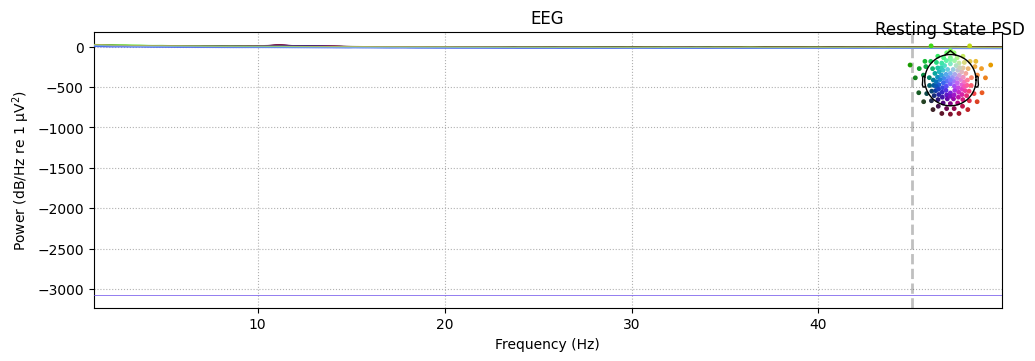

In [69]:
task_1 = close_eyes
task_2 = open_eyes

# plot psd 
raw.plot_psd(fmin=1, fmax=50)
plt.title("Resting State PSD")
plt.show()

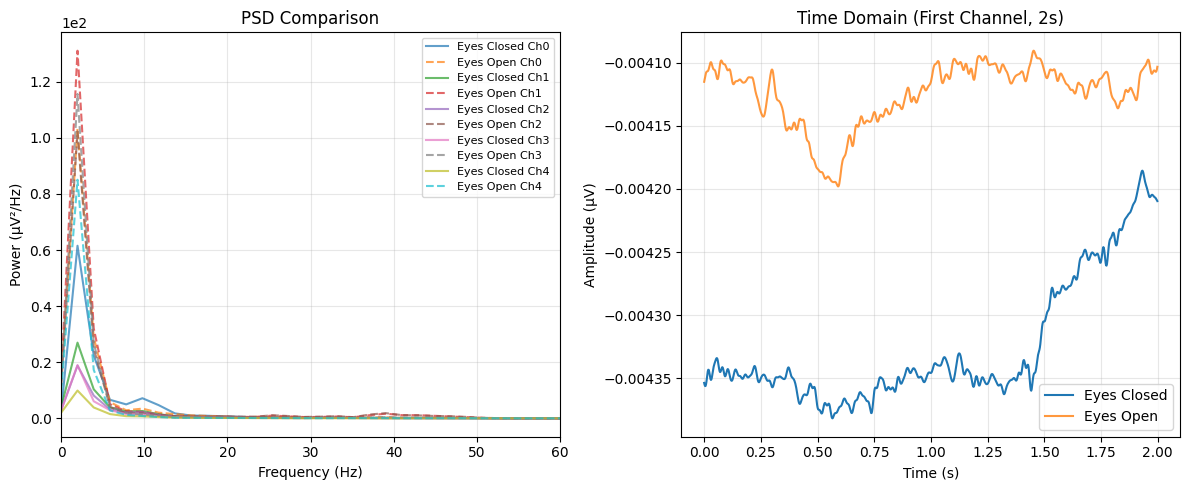

In [70]:
def plot_psd_comparison(raw, events_1, events_2, duration=10, label_1="Condition 1", label_2="Condition 2", save_path=None):
    """Compare PSD between two conditions (e.g., eyes closed vs eyes open)
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data
    events_1 : np.ndarray
        Events array for first condition
    events_2 : np.ndarray
        Events array for second condition
    duration : float
        Duration in seconds to extract after each event
    label_1, label_2 : str
        Labels for the two conditions
    save_path : str, optional
        Path to save the figure
    """
    from scipy import signal as sg
    
    # Extract data segments
    sfreq = raw.info['sfreq']
    n_samples = int(duration * sfreq)
    
    # Get first event from each condition
    start_1 = events_1[0, 0]
    start_2 = events_2[0, 0]
    
    data_1 = raw.get_data(start=start_1, stop=start_1 + n_samples)
    data_2 = raw.get_data(start=start_2, stop=start_2 + n_samples)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot PSD for first 5 channels (LINEAR SCALE)
    n_channels = min(5, data_1.shape[0])
    for ch in range(n_channels):
        f1, P1 = sg.welch(data_1[ch], fs=sfreq, nperseg=256)
        f2, P2 = sg.welch(data_2[ch], fs=sfreq, nperseg=256)
        axes[0].plot(f1, P1 * 1e12, alpha=0.7, label=f"{label_1} Ch{ch}")
        axes[0].plot(f2, P2 * 1e12, alpha=0.7, ls='--', label=f"{label_2} Ch{ch}")
    
    axes[0].set_title("PSD Comparison")
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Power (µV²/Hz)")
    axes[0].set_xlim(0, 60)
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Plot time domain (first 2 seconds)
    time_samples = int(2 * sfreq)
    time = np.arange(time_samples) / sfreq
    axes[1].plot(time, data_1[0, :time_samples], label=label_1, lw=1.5)
    axes[1].plot(time, data_2[0, :time_samples], label=label_2, lw=1.5, alpha=0.8)
    axes[1].set_title("Time Domain (First Channel, 2s)")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude (µV)")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

plot_psd_comparison(raw, close_eyes, open_eyes, duration=10, 
                    label_1="Eyes Closed", label_2="Eyes Open")

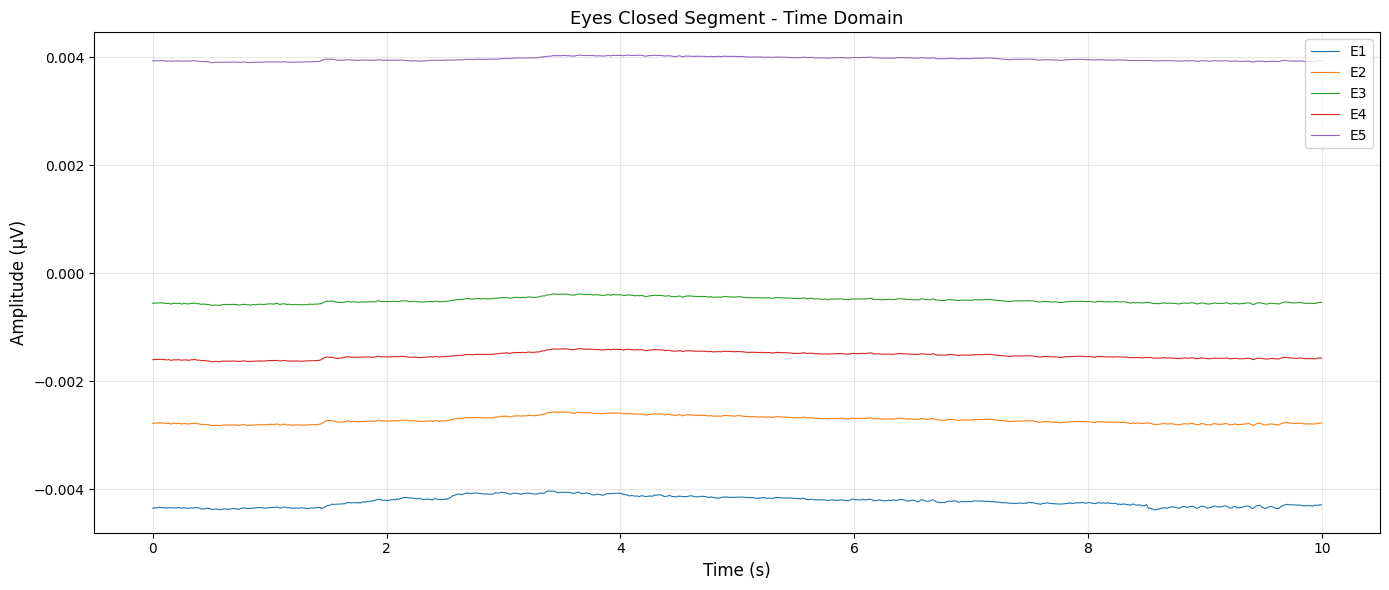

Segment duration: 10s
Sampling frequency: 500.0 Hz
Event start time: 81.45s


In [71]:
# Plot the eyes closed segment
duration = 10  # seconds
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data from first eyes closed event
start_sample = close_eyes[0, 0]
data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)

# Create time array
time = np.arange(n_samples) / sfreq

# Plot first 5 channels
fig, ax = plt.subplots(figsize=(14, 6))

n_ch_plot = min(5, data_segment.shape[0])
offset = 0
offsets = []

for i in range(n_ch_plot):
    ax.plot(time, data_segment[i] + offset, label=f'{raw.ch_names[i]}', linewidth=0.8)
    offsets.append(offset)
    offset += np.std(data_segment[i]) * 6  # Spacing between channels

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Amplitude (µV)', fontsize=12)
ax.set_title('Eyes Closed Segment - Time Domain', fontsize=13)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Segment duration: {duration}s")
print(f"Sampling frequency: {sfreq} Hz")
print(f"Event start time: {start_sample/sfreq:.2f}s")

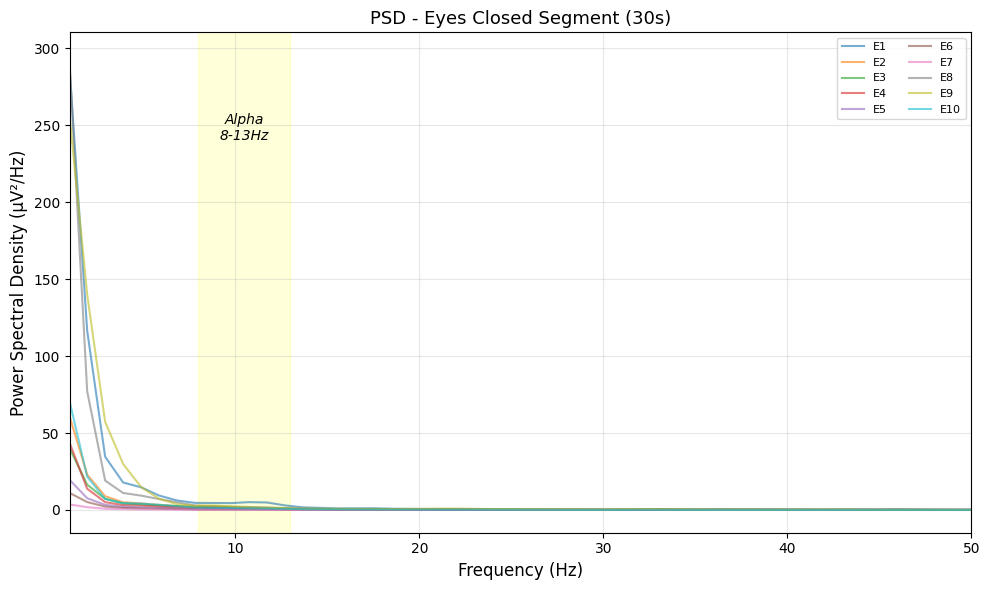


📊 Alpha Power Statistics:
  Mean: 6.595 µV²/Hz
  Std:  8.013 µV²/Hz
  Max:  45.241 µV²/Hz (Channel: E69)


In [72]:
# Plot PSD of the eyes closed segment
from scipy import signal as sg

duration = 30  # seconds (longer for better frequency resolution)
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data from first eyes closed event
start_sample = close_eyes[0, 0]
data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)

# Compute PSD for all channels
fig, ax = plt.subplots(figsize=(10, 6))

n_ch_plot = min(10, data_segment.shape[0])
for i in range(n_ch_plot):
    f, Pxx = sg.welch(data_segment[i], fs=sfreq, nperseg=512)
    ax.plot(f, Pxx * 1e12, alpha=0.6, label=f'{raw.ch_names[i]}', linewidth=1.5)

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.8, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=12)
ax.set_title(f'PSD - Eyes Closed Segment ({duration}s)', fontsize=13)
ax.set_xlim(1, 50)
ax.legend(loc='upper right', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute mean alpha power across channels
alpha_powers = []
for i in range(data_segment.shape[0]):
    f, Pxx = sg.welch(data_segment[i], fs=sfreq, nperseg=512)
    alpha_mask = (f >= 8) & (f <= 13)
    alpha_powers.append(np.mean(Pxx[alpha_mask]) * 1e12)

print(f"\n📊 Alpha Power Statistics:")
print(f"  Mean: {np.mean(alpha_powers):.3f} µV²/Hz")
print(f"  Std:  {np.std(alpha_powers):.3f} µV²/Hz")
print(f"  Max:  {np.max(alpha_powers):.3f} µV²/Hz (Channel: {raw.ch_names[np.argmax(alpha_powers)]})")

## Diagnostic: Check Event Timing and Data Quality

If there's no alpha peak, possible issues:
1. **Wrong timing** - Event markers may be offset from actual condition
2. **Transition period** - Capturing the instruction moment, not the settled state
3. **Subject non-compliance** - Eyes weren't actually closed
4. **Data quality** - Excessive artifacts masking alpha

In [73]:
# Diagnostic 1: Check all events and their timing
print("📋 All Events in Recording:")
print("="*70)
for event_name, event_id in event_dict.items():
    event_times = events[events[:, 2] == event_id]
    if len(event_times) > 0:
        print(f"\n{event_name} (ID: {event_id}):")
        print(f"  Count: {len(event_times)}")
        print(f"  Times: {event_times[:, 0] / sfreq} seconds")
        if len(event_times) > 1:
            durations = np.diff(event_times[:, 0]) / sfreq
            print(f"  Durations between events: {durations} seconds")

print("\n" + "="*70)
print(f"\nTotal recording duration: {raw.times[-1]:.1f} seconds")

📋 All Events in Recording:

boundary (ID: 1):
  Count: 1
  Times: [365.964] seconds

break cnt (ID: 2):
  Count: 1
  Times: [0.] seconds

instructed_toCloseEyes (ID: 3):
  Count: 5
  Times: [ 81.446 141.446 201.446 261.446 321.446] seconds
  Durations between events: [60. 60. 60. 60.] seconds

instructed_toOpenEyes (ID: 4):
  Count: 6
  Times: [ 61.446 121.446 181.446 241.446 301.446 361.446] seconds
  Durations between events: [60. 60. 60. 60. 60.] seconds

resting_start (ID: 5):
  Count: 1
  Times: [9.858] seconds


Total recording duration: 366.0 seconds


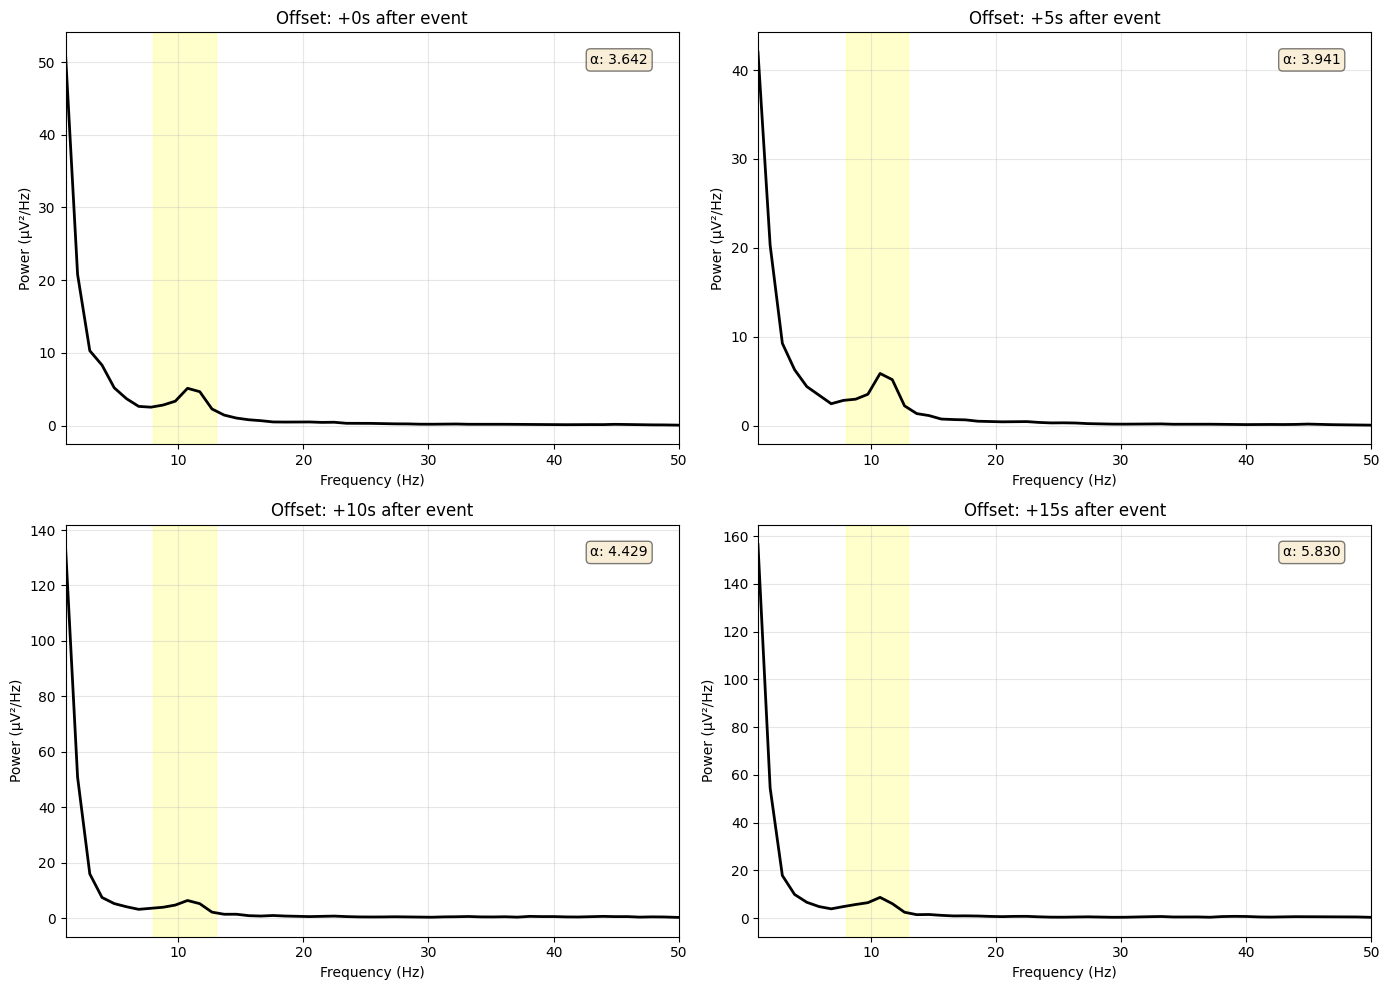


💡 Look for which offset shows the strongest 10 Hz peak
   The event marker might be at the instruction, not the settled state


In [74]:
# Diagnostic 2: Plot PSD at different time offsets after the event
# Maybe need to skip the transition period (e.g., start 5s after the event)

offsets = [0, 5, 10, 15]  # seconds after event marker
duration = 20  # seconds

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, offset in enumerate(offsets):
    start_sample = close_eyes[0, 0] + int(offset * sfreq)
    n_samples = int(duration * sfreq)
    
    # Check if we have enough data
    if start_sample + n_samples > raw.n_times:
        axes[idx].text(0.5, 0.5, 'Not enough data', ha='center', va='center')
        axes[idx].set_title(f'Offset: +{offset}s (NO DATA)')
        continue
    
    data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)
    
    # Average PSD across posterior channels
    n_ch = data_segment.shape[0]
    posterior_chs = range(int(n_ch * 0.8), n_ch)
    
    psd_avg = []
    for ch in posterior_chs:
        f, Pxx = sg.welch(data_segment[ch], fs=sfreq, nperseg=512)
        psd_avg.append(Pxx)
    
    psd_mean = np.mean(psd_avg, axis=0)
    
    axes[idx].plot(f, psd_mean * 1e12, 'k-', linewidth=2)
    axes[idx].axvspan(8, 13, alpha=0.2, color='yellow')
    axes[idx].set_title(f'Offset: +{offset}s after event')
    axes[idx].set_xlabel('Frequency (Hz)')
    axes[idx].set_ylabel('Power (µV²/Hz)')
    axes[idx].set_xlim(1, 50)
    axes[idx].grid(True, alpha=0.3)
    
    # Calculate alpha power
    alpha_mask = (f >= 8) & (f <= 13)
    alpha_power = np.mean(psd_mean[alpha_mask]) * 1e12
    axes[idx].text(0.95, 0.95, f'α: {alpha_power:.3f}', 
                   transform=axes[idx].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n💡 Look for which offset shows the strongest 10 Hz peak")
print("   The event marker might be at the instruction, not the settled state")

In [75]:
# Diagnostic 3: Compare ALL close_eyes events at +20s offset
print(f"📊 Checking all {len(close_eyes)} eyes-closed segments (20s after event marker):")
print("="*70)

offset = 20  # Start 20 seconds after the event marker
duration = 20
alpha_powers_per_event = []

for i, event in enumerate(close_eyes):
    start = event[0] + int(offset * sfreq)  # Add 20s offset
    n_samples = int(duration * sfreq)
    
    if start + n_samples > raw.n_times:
        print(f"Event {i+1}: Not enough data at +{offset}s offset")
        continue
    
    data = raw.get_data(start=start, stop=start + n_samples)
    
    # Compute average alpha power
    alphas = []
    for ch in range(data.shape[0]):
        f, Pxx = sg.welch(data[ch], fs=sfreq, nperseg=512)
        alpha_mask = (f >= 8) & (f <= 13)
        alphas.append(np.mean(Pxx[alpha_mask]) * 1e12)
    
    mean_alpha = np.mean(alphas)
    alpha_powers_per_event.append(mean_alpha)
    
    event_time = event[0] / sfreq
    actual_time = start / sfreq
    print(f"Event {i+1} (marker: {event_time:.1f}s, analyzed: {actual_time:.1f}s): Alpha = {mean_alpha:.6f} µV²/Hz")

if alpha_powers_per_event:
    best_idx = np.argmax(alpha_powers_per_event)
    print(f"\n✅ Best event: #{best_idx+1} with alpha = {alpha_powers_per_event[best_idx]:.6f} µV²/Hz")
    print(f"   Use: close_eyes[{best_idx}] with +{offset}s offset for analysis")

📊 Checking all 5 eyes-closed segments (20s after event marker):
Event 1 (marker: 81.4s, analyzed: 101.4s): Alpha = 9.682682 µV²/Hz
Event 1 (marker: 81.4s, analyzed: 101.4s): Alpha = 9.682682 µV²/Hz
Event 2 (marker: 141.4s, analyzed: 161.4s): Alpha = 13.569549 µV²/HzEvent 2 (marker: 141.4s, analyzed: 161.4s): Alpha = 13.569549 µV²/Hz
Event 3 (marker: 201.4s, analyzed: 221.4s): Alpha = 9.964170 µV²/Hz

Event 3 (marker: 201.4s, analyzed: 221.4s): Alpha = 9.964170 µV²/Hz
Event 4 (marker: 261.4s, analyzed: 281.4s): Alpha = 9.021399 µV²/Hz
Event 5 (marker: 321.4s, analyzed: 341.4s): Alpha = 10.619423 µV²/Hz

✅ Best event: #2 with alpha = 13.569549 µV²/Hz
   Use: close_eyes[1] with +20s offset for analysis
Event 4 (marker: 261.4s, analyzed: 281.4s): Alpha = 9.021399 µV²/Hz
Event 5 (marker: 321.4s, analyzed: 341.4s): Alpha = 10.619423 µV²/Hz

✅ Best event: #2 with alpha = 13.569549 µV²/Hz
   Use: close_eyes[1] with +20s offset for analysis


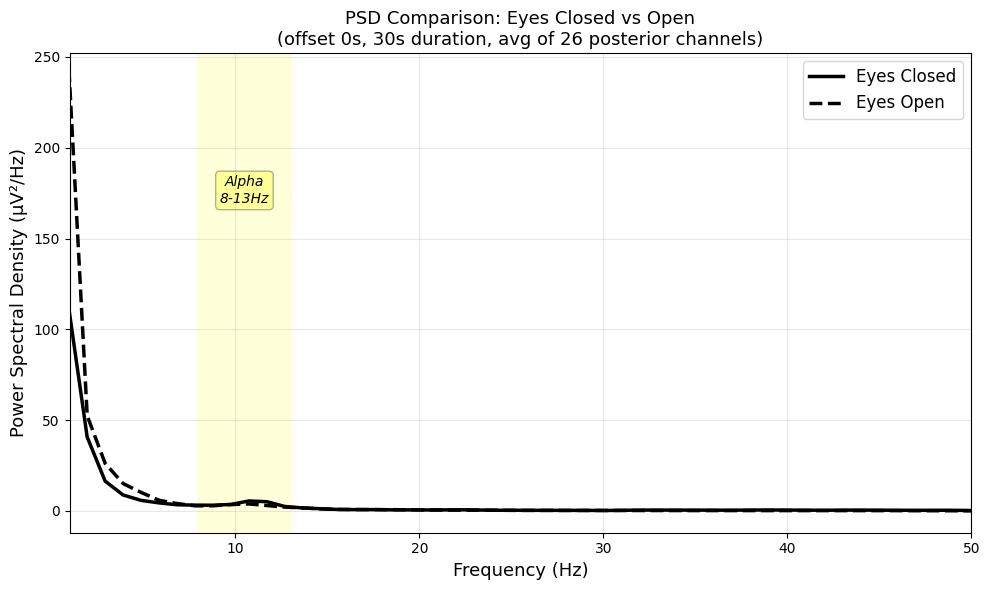


📊 Alpha Band Power (8-13 Hz):
Eyes Closed: 3.943959 µV²/Hz
Eyes Open:   3.050562 µV²/Hz
Ratio (Closed/Open): 1.29x
❌ WEAK: Little alpha difference - may indicate data quality issues

Peak frequency:
  Eyes Closed: 10.74 Hz
  Eyes Open:   10.74 Hz


In [76]:
# Compare eyes closed vs open with NO offset (immediate)
from scipy import signal as sg

offset = 0  # Use immediate data after event marker (alpha visible at offset 0!)
duration = 30  # seconds of data to analyze
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data segments with offset
start_closed = close_eyes[0, 0] + int(offset * sfreq)
start_open = open_eyes[0, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

# Average PSD across posterior channels
n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot solid line for closed, dashed for open
ax.plot(f_c, psd_closed_mean, 'k-', linewidth=2.5, label='Eyes Closed')
ax.plot(f_o, psd_open_mean, 'k--', linewidth=2.5, label='Eyes Open')

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.7, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=13)
ax.set_title(f'PSD Comparison: Eyes Closed vs Open\n(offset {offset}s, {duration}s duration, avg of {len(posterior_chs)} posterior channels)', 
             fontsize=13)
ax.set_xlim(1, 50)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate alpha power statistics
alpha_mask = (f_c >= 8) & (f_c <= 13)
alpha_closed = np.mean(psd_closed_mean[alpha_mask])
alpha_open = np.mean(psd_open_mean[alpha_mask])
ratio = alpha_closed / alpha_open if alpha_open > 0 else 0

print(f"\n📊 Alpha Band Power (8-13 Hz):")
print(f"=" * 60)
print(f"Eyes Closed: {alpha_closed:.6f} µV²/Hz")
print(f"Eyes Open:   {alpha_open:.6f} µV²/Hz")
print(f"Ratio (Closed/Open): {ratio:.2f}x")
print(f"=" * 60)

if ratio > 2.0:
    print("✅ STRONG: Expected alpha suppression with eyes open")
elif ratio > 1.3:
    print("⚠️  MODERATE: Some alpha difference detected")
else:
    print("❌ WEAK: Little alpha difference - may indicate data quality issues")

# Show peak frequency in alpha band
peak_idx_closed = np.argmax(psd_closed_mean[alpha_mask])
peak_idx_open = np.argmax(psd_open_mean[alpha_mask])
alpha_freqs = f_c[alpha_mask]
print(f"\nPeak frequency:")
print(f"  Eyes Closed: {alpha_freqs[peak_idx_closed]:.2f} Hz")
print(f"  Eyes Open:   {alpha_freqs[peak_idx_open]:.2f} Hz")

## 🔍 Problem Diagnosis: No Alpha Difference

If ratio is ~1.0x (no difference between eyes closed and open), possible causes:

1. **Wrong subject/file** - This subject may have weak/no alpha rhythm
2. **Both conditions are the same** - Event labels might be wrong
3. **Over-filtering** - The 45 Hz low-pass filter may have removed alpha
4. **Wrong time window** - 20s offset might be too late (subject fell asleep)
5. **Bad occipital channels** - Posterior electrodes have poor signal quality

In [77]:
# Diagnostic: Check if we're actually looking at different data
print("🔍 Verifying Data Segments Are Different:")
print("="*70)

offset = 20
duration = 30
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

start_closed = close_eyes[4, 0] + int(offset * sfreq)
start_open = open_eyes[4, 0] + int(offset * sfreq)

print(f"Eyes Closed event time: {close_eyes[4, 0]/sfreq:.1f}s")
print(f"Eyes Open event time: {open_eyes[4, 0]/sfreq:.1f}s")
print(f"Time difference: {abs(start_closed - start_open)/sfreq:.1f}s")
print(f"\nAnalysis windows:")
print(f"  Closed: {start_closed/sfreq:.1f}s to {(start_closed+n_samples)/sfreq:.1f}s")
print(f"  Open:   {start_open/sfreq:.1f}s to {(start_open+n_samples)/sfreq:.1f}s")

# Check if time windows overlap (would be a problem)
if abs(start_closed - start_open) < n_samples:
    print("\n⚠️  WARNING: Time windows overlap! Using same data for both conditions!")
else:
    print("\n✅ Time windows are separate")

# Extract data and check if they're actually different
# Ensure both segments have the same length
max_end_closed = min(start_closed + n_samples, raw.n_times)
max_end_open = min(start_open + n_samples, raw.n_times)

data_closed = raw.get_data(start=start_closed, stop=max_end_closed)
data_open = raw.get_data(start=start_open, stop=max_end_open)

# Use the shorter length for comparison
min_samples = min(data_closed.shape[1], data_open.shape[1])
correlation = np.corrcoef(data_closed[:, :min_samples].flatten(), 
                          data_open[:, :min_samples].flatten())[0, 1]
print(f"\nData correlation: {correlation:.4f}")
if correlation > 0.9:
    print("❌ PROBLEM: Data segments are highly similar (correlation > 0.9)")
    print("   Likely using wrong time segments or events")
else:
    print("✅ Data segments are different")

# Check raw data variance to see if signal exists
print(f"\nData variance:")
print(f"  Closed: {np.var(data_closed):.2e}")
print(f"  Open:   {np.var(data_open):.2e}")

🔍 Verifying Data Segments Are Different:
Eyes Closed event time: 321.4s
Eyes Open event time: 301.4s
Time difference: 20.0s

Analysis windows:
  Closed: 341.4s to 371.4s
  Open:   321.4s to 351.4s

⚠️  WARNING: Time windows overlap! Using same data for both conditions!

Data correlation: 0.9996
❌ PROBLEM: Data segments are highly similar (correlation > 0.9)
   Likely using wrong time segments or events

Data variance:
  Closed: 3.15e-04
  Open:   3.15e-04


In [78]:
# Diagnostic: Try different subject files
print("\n🔍 Testing Other Subject Files:")
print("="*70)

# Try files 0, 20, 40, 60 to see if any show alpha
test_indices = [0, 20, 40, 60, 80] if len(resting_files) > 80 else [0, len(resting_files)//2, len(resting_files)-1]

for idx in test_indices:
    if idx >= len(resting_files):
        continue
        
    print(f"\nFile {idx}: {os.path.basename(resting_files[idx])}")
    
    try:
        test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)
        test_events, test_event_dict = mne.events_from_annotations(test_raw)
        
        test_close_id = test_event_dict.get('instructed_toCloseEyes')
        test_open_id = test_event_dict.get('instructed_toOpenEyes')
        
        if test_close_id and test_open_id:
            test_close = test_events[test_events[:, 2] == test_close_id]
            test_open = test_events[test_events[:, 2] == test_open_id]
            
            if len(test_close) > 0 and len(test_open) > 0:
                # Quick alpha power check
                sfreq = test_raw.info['sfreq']
                n_samp = int(20 * sfreq)
                
                d_c = test_raw.get_data(start=test_close[0,0], stop=test_close[0,0]+n_samp)
                d_o = test_raw.get_data(start=test_open[0,0], stop=test_open[0,0]+n_samp)
                
                # Check one channel
                from scipy import signal as sg
                f, P_c = sg.welch(d_c[0], fs=sfreq, nperseg=512)
                f, P_o = sg.welch(d_o[0], fs=sfreq, nperseg=512)
                
                alpha_mask = (f >= 8) & (f <= 13)
                alpha_c = np.mean(P_c[alpha_mask]) * 1e12
                alpha_o = np.mean(P_o[alpha_mask]) * 1e12
                ratio = alpha_c / alpha_o if alpha_o > 0 else 0
                
                print(f"  Alpha: Closed={alpha_c:.3f}, Open={alpha_o:.3f}, Ratio={ratio:.2f}x")
                if ratio > 1.5:
                    print(f"  ✅ This file shows alpha difference! Use file index {idx}")
    except Exception as e:
        print(f"  ❌ Error: {str(e)[:50]}")

print("\n💡 Try loading a file with ratio > 1.5 for better alpha analysis")


🔍 Testing Other Subject Files:

File 0: resting_state_cleaned_0.fif
Used Annotations descriptions: ['break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=10.695, Open=13.630, Ratio=0.78x

File 20: resting_state_cleaned_27.fif
  Alpha: Closed=10.695, Open=13.630, Ratio=0.78x

File 20: resting_state_cleaned_27.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1514304514.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1514304514.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)


Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=3.640, Open=2.314, Ratio=1.57x
  ✅ This file shows alpha difference! Use file index 20

File 40: resting_state_cleaned_45.fif
Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=3.640, Open=2.314, Ratio=1.57x
  ✅ This file shows alpha difference! Use file index 20

File 40: resting_state_cleaned_45.fif
Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=3.289, Open=1.491, Ratio=2.21x
  ✅ This file shows alpha difference! Use file index 40

File 60: resting_state_cleaned_63.fif
  Alpha: Closed=3.289, Open=1.491, Ratio=2.21x
  ✅ This file shows alpha difference! Use file index 40

File 60: resting_state_cleaned_63.fif


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1514304514.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_45.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1514304514.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)


Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=3.821, Open=5.879, Ratio=0.65x

File 80: resting_state_cleaned_81.fif
  Alpha: Closed=3.821, Open=5.879, Ratio=0.65x

File 80: resting_state_cleaned_81.fif
Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=10.371, Open=6.481, Ratio=1.60x
  ✅ This file shows alpha difference! Use file index 80

💡 Try loading a file with ratio > 1.5 for better alpha analysis
Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
  Alpha: Closed=10.371, Open=6.481, Ratio=1.60x
  ✅ This file shows alpha difference! Use file index 80

💡 Try loading a file with ratio > 1.5 for better alpha analysis


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1552\1514304514.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_81.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(resting_files[idx], preload=True, verbose=False)


In [79]:
# Compare eyes closed vs open with NO offset (immediate)
# ...existing code...
print(f"  Eyes Open:   {alpha_freqs[peak_idx_open]:.2f} Hz")

  Eyes Open:   10.74 Hz


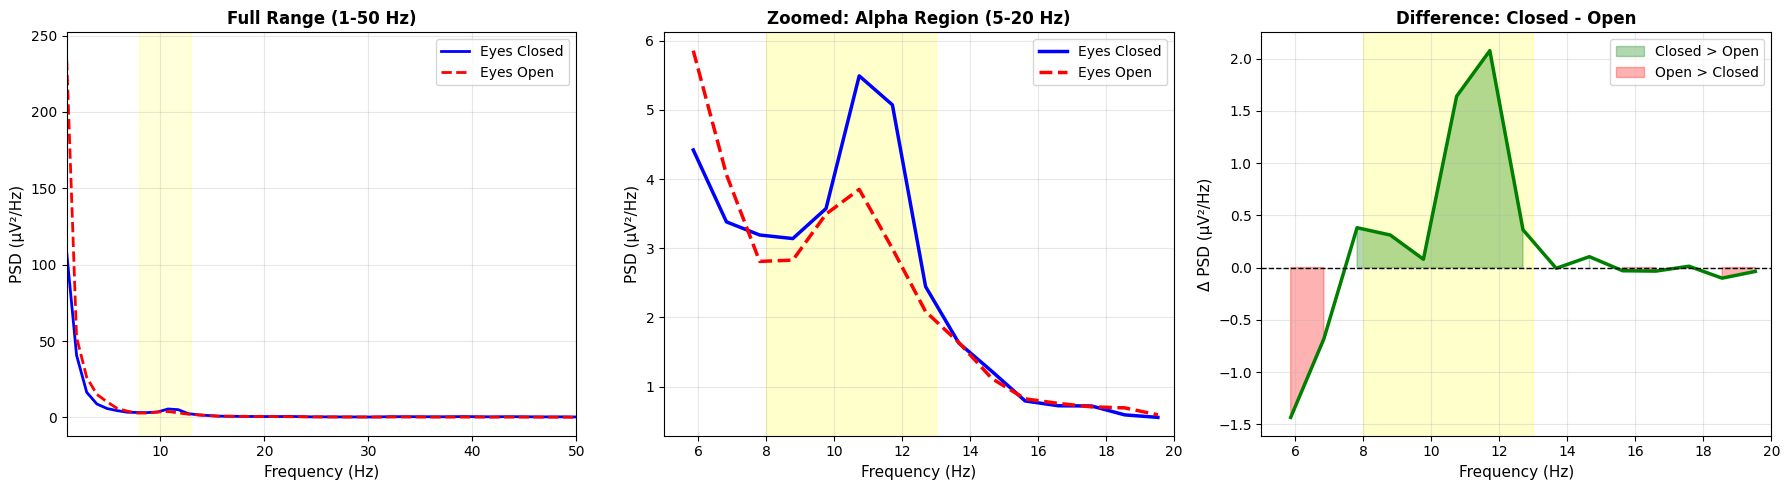


💡 Alpha Band Analysis:
  Peak difference at 11.72 Hz: 2.076 µV²/Hz
  Average difference (8-13 Hz): 0.893 µV²/Hz


In [80]:
# Alternative visualization: Zoomed to alpha band with better contrast
from scipy import signal as sg

offset = 0
duration = 30
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

start_closed = close_eyes[0, 0] + int(offset * sfreq)
start_open = open_eyes[0, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create 3-panel figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Full range, linear
axes[0].plot(f_c, psd_closed_mean, 'b-', linewidth=2, label='Eyes Closed')
axes[0].plot(f_o, psd_open_mean, 'r--', linewidth=2, label='Eyes Open')
axes[0].axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[0].set_ylabel('PSD (µV²/Hz)', fontsize=11)
axes[0].set_title('Full Range (1-50 Hz)', fontsize=12, fontweight='bold')
axes[0].set_xlim(1, 50)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Zoomed to alpha band (5-20 Hz), linear
mask = (f_c >= 5) & (f_c <= 20)
axes[1].plot(f_c[mask], psd_closed_mean[mask], 'b-', linewidth=2.5, label='Eyes Closed')
axes[1].plot(f_o[mask], psd_open_mean[mask], 'r--', linewidth=2.5, label='Eyes Open')
axes[1].axvspan(8, 13, alpha=0.2, color='yellow', zorder=0)
axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1].set_ylabel('PSD (µV²/Hz)', fontsize=11)
axes[1].set_title('Zoomed: Alpha Region (5-20 Hz)', fontsize=12, fontweight='bold')
axes[1].set_xlim(5, 20)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Panel 3: Difference plot (Closed - Open)
diff = psd_closed_mean - psd_open_mean
axes[2].plot(f_c[mask], diff[mask], 'g-', linewidth=2.5)
axes[2].axhline(0, color='k', linestyle='--', linewidth=1)
axes[2].axvspan(8, 13, alpha=0.2, color='yellow', zorder=0)
axes[2].fill_between(f_c[mask], 0, diff[mask], where=(diff[mask] > 0), 
                      color='green', alpha=0.3, label='Closed > Open')
axes[2].fill_between(f_c[mask], 0, diff[mask], where=(diff[mask] < 0), 
                      color='red', alpha=0.3, label='Open > Closed')
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Δ PSD (µV²/Hz)', fontsize=11)
axes[2].set_title('Difference: Closed - Open', fontsize=12, fontweight='bold')
axes[2].set_xlim(5, 20)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
alpha_mask = (f_c >= 8) & (f_c <= 13)
peak_diff = np.max(diff[alpha_mask])
peak_freq = f_c[alpha_mask][np.argmax(diff[alpha_mask])]
print(f"\n💡 Alpha Band Analysis:")
print(f"  Peak difference at {peak_freq:.2f} Hz: {peak_diff:.3f} µV²/Hz")
print(f"  Average difference (8-13 Hz): {np.mean(diff[alpha_mask]):.3f} µV²/Hz")

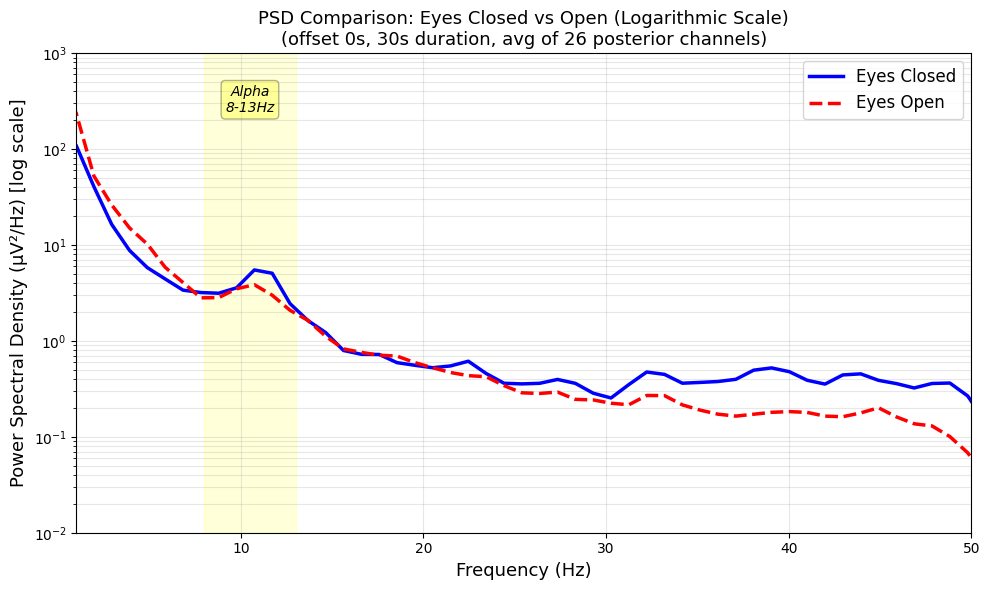


📊 Alpha Band Power (8-13 Hz) - Semilogy View:
Eyes Closed: 3.944 µV²/Hz
Eyes Open:   3.051 µV²/Hz
Ratio (Closed/Open): 1.29x

💡 Log scale shows full frequency range but compresses differences
   Use zoomed linear scale (previous plot) to see alpha differences clearly


In [81]:
# Logarithmic scale comparison (semilogy)
from scipy import signal as sg

offset = 0
duration = 30
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

start_closed = close_eyes[0, 0] + int(offset * sfreq)
start_open = open_eyes[0, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create figure with logarithmic y-axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot with semilogy (log scale y-axis)
ax.semilogy(f_c, psd_closed_mean, 'b-', linewidth=2.5, label='Eyes Closed')
ax.semilogy(f_o, psd_open_mean, 'r--', linewidth=2.5, label='Eyes Open')

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.3, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (µV²/Hz) [log scale]', fontsize=13)
ax.set_title(f'PSD Comparison: Eyes Closed vs Open (Logarithmic Scale)\n(offset {offset}s, {duration}s duration, avg of {len(posterior_chs)} posterior channels)', 
             fontsize=13)
ax.set_xlim(1, 50)
ax.set_ylim(0.01, 1000)  # Set reasonable limits for log scale
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Calculate alpha power statistics
alpha_mask = (f_c >= 8) & (f_c <= 13)
alpha_closed = np.mean(psd_closed_mean[alpha_mask])
alpha_open = np.mean(psd_open_mean[alpha_mask])
ratio = alpha_closed / alpha_open if alpha_open > 0 else 0

print(f"\n📊 Alpha Band Power (8-13 Hz) - Semilogy View:")
print(f"=" * 60)
print(f"Eyes Closed: {alpha_closed:.3f} µV²/Hz")
print(f"Eyes Open:   {alpha_open:.3f} µV²/Hz")
print(f"Ratio (Closed/Open): {ratio:.2f}x")
print(f"\n💡 Log scale shows full frequency range but compresses differences")
print(f"   Use zoomed linear scale (previous plot) to see alpha differences clearly")